# Lab 2

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
import glob
import gzip
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


## Question 1 : Non-homogeneous Poisson process and trade times.

### 1.1 Thining Algorithm


████████████████████████████████████████████████████████████████████████████████
PART 1: ALGORITHM DEMONSTRATION
████████████████████████████████████████████████████████████████████████████████
STEP-BY-STEP DEMONSTRATION OF THINNING ALGORITHM (INTERARRIVAL TIME)

Intensity function: λ(t) = 3 + 2*sin(πt/5)
Time horizon: T = 20
λ* = 5.5000

Starting simulation with λ* = 5.5000
Step   s          t+s        u          λ(t+s)/λ*    Accept? 
----------------------------------------------------------------------
0      0.1786     0.1786     0.9507     0.5862       No      
1      0.0567     0.2353     0.5987     0.5990       Yes     
2      0.3378     0.5731     0.1560     0.6736       Yes     
3      0.5174     1.0905     0.8662     0.7756       No      
4      0.0925     1.1830     0.7081     0.7915       Yes     
5      0.7060     1.8891     0.9699     0.8826       No      
6      0.0333     1.9224     0.2123     0.8854       Yes     
7      0.3099     2.2324     0.1834     0.9040       Y

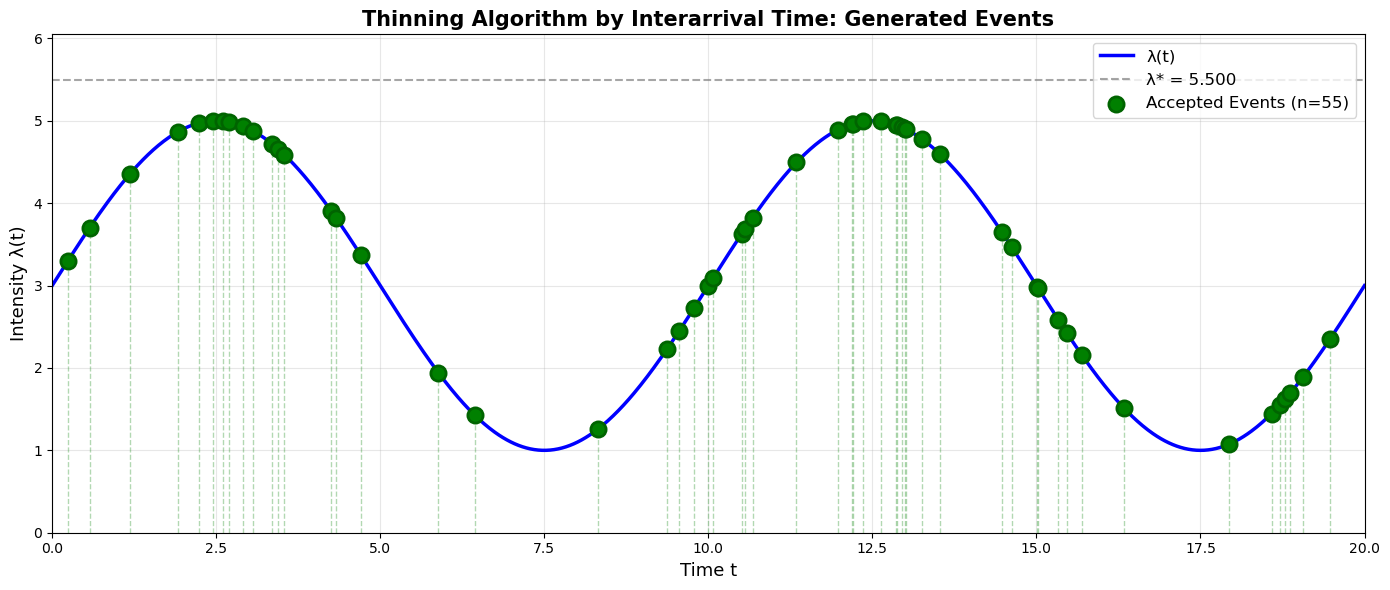

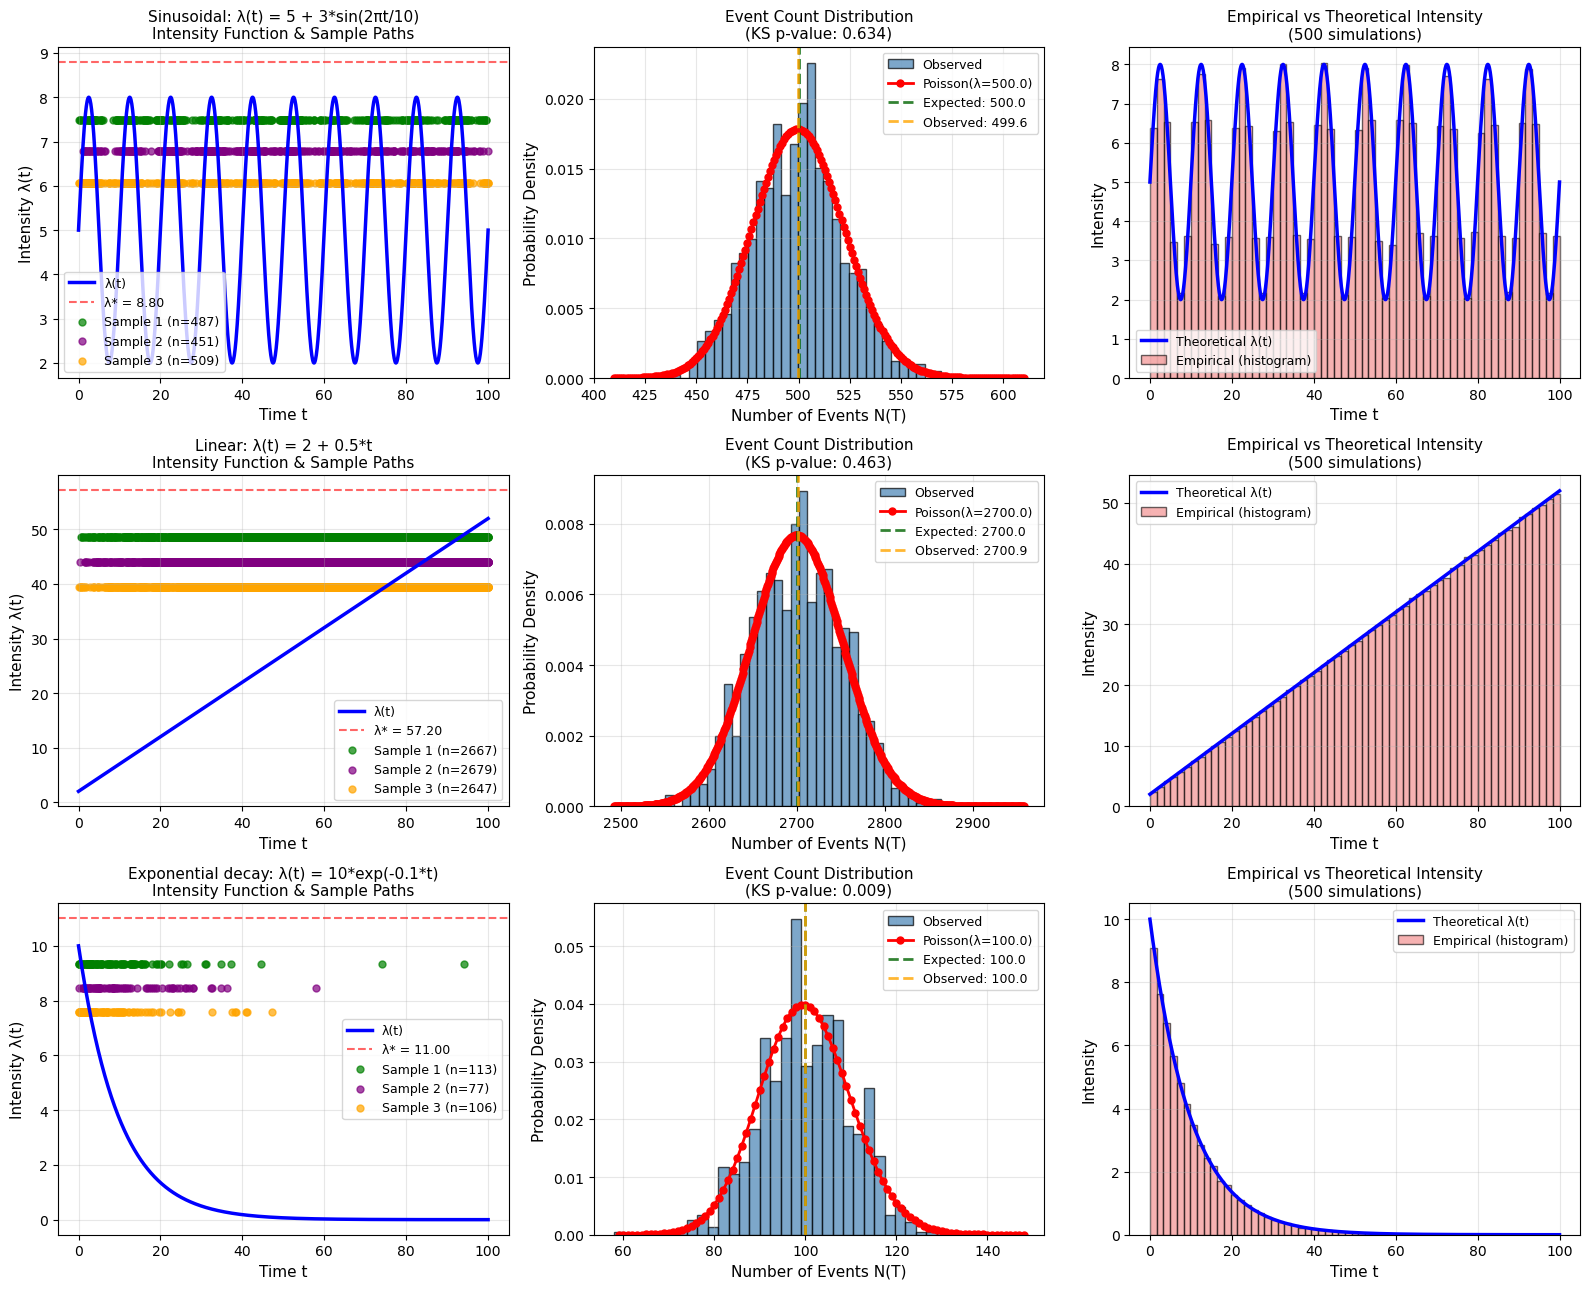

In [17]:
class NonHomogeneousPoissonProcess:
    """
    Simulate non-homogeneous Poisson process using thinning algorithm
    by interarrival time
    """
    
    def __init__(self, intensity_func, T, lambda_max=None):
        """
        Parameters:
        -----------
        intensity_func : callable
            Intensity function λ(t) or μ(t)
        T : float
            Time horizon
        lambda_max : float, optional
            Upper bound on intensity λ*. If None, will be estimated
        """
        self.lambda_func = intensity_func
        self.T = T
        
        # Find maximum intensity λ*
        if lambda_max is None:
            # Sample the function to find approximate maximum
            t_grid = np.linspace(0, T, 10000)
            self.lambda_star = np.max(self.lambda_func(t_grid)) * 1.1  # Add 10% safety margin
        else:
            self.lambda_star = lambda_max
    
    def simulate(self, seed=None, verbose=False):
        """
        Simulate using thinning by interarrival time (exact pseudocode)
        
        Algorithm:
        1. t = 0, i = 1
        2. Generate s ~ E(λ*) 
        3. If t + s ≤ T:
           3.1 Generate u ~ U[0,1]
           3.2 If u ≤ λ(t+s)/λ*: Set t_i = t + s, i = i + 1
           3.3 t = t + s
           3.4 Go to 2
        4. Else: Return (t_i)_{i≥1}
        
        Returns:
        --------
        events : array
            Array of event times
        """
        if seed is not None:
            np.random.seed(seed)
        
        events = []
        t = 0  # Step 1
        i = 1  # Step 1
        
        if verbose:
            print(f"Starting simulation with λ* = {self.lambda_star:.4f}")
            print(f"{'Step':<6} {'s':<10} {'t+s':<10} {'u':<10} {'λ(t+s)/λ*':<12} {'Accept?':<8}")
            print("-" * 70)
        
        iteration = 0
        while True:  # Step 2 and loop
            # Step 2: Generate s ~ E(λ*)
            # s = -1/λ* * log(u) where u ~ U[0,1]
            u_exp = np.random.uniform(0, 1)
            s = -1/self.lambda_star * np.log(u_exp)
            
            # Step 3: Check if t + s ≤ T
            if t + s <= self.T:
                # Step 3.1: Generate u ~ U[0,1]
                u = np.random.uniform(0, 1)
                
                # Step 3.2: Check if u ≤ λ(t+s)/λ*
                lambda_ratio = self.lambda_func(t + s) / self.lambda_star
                
                if verbose and iteration < 15:  # Show first 15 iterations
                    print(f"{iteration:<6} {s:<10.4f} {t+s:<10.4f} {u:<10.4f} {lambda_ratio:<12.4f} {'Yes' if u <= lambda_ratio else 'No':<8}")
                
                if u <= lambda_ratio:
                    # Accept: Set t_i = t + s, i = i + 1
                    events.append(t + s)
                    i = i + 1
                
                # Step 3.3: t = t + s
                t = t + s
                iteration += 1
                
                # Step 3.4: Go to 2 (continue loop)
            else:
                # Step 4: Return events
                if verbose:
                    print(f"\nSimulation ended: t + s = {t + s:.4f} > T = {self.T}")
                    print(f"Total events generated: {len(events)}")
                break
        
        return np.array(events)
    
    def expected_number(self):
        """
        Expected number of events in [0,T]
        E[N(T)] = ∫_0^T λ(s) ds
        """
        result, _ = quad(self.lambda_func, 0, self.T)
        return result


# Test Case 1: Sinusoidal intensity
def lambda1(t):
    """Intensity: 5 + 3*sin(2πt/10)"""
    return 5 + 3 * np.sin(2 * np.pi * t / 10)

# Test Case 2: Linear intensity
def lambda2(t):
    """Intensity: 2 + 0.5*t"""
    return 2 + 0.5 * t

# Test Case 3: Exponential decay
def lambda3(t):
    """Intensity: 10*exp(-0.1*t)"""
    return 10 * np.exp(-0.1 * t)


def demonstrate_algorithm():
    """
    Demonstrate the thinning algorithm step-by-step
    """
    print("=" * 80)
    print("STEP-BY-STEP DEMONSTRATION OF THINNING ALGORITHM (INTERARRIVAL TIME)")
    print("=" * 80)
    
    def lambda_demo(t):
        return 3 + 2 * np.sin(np.pi * t / 5)
    
    T = 20
    nhpp = NonHomogeneousPoissonProcess(lambda_demo, T)
    
    print(f"\nIntensity function: λ(t) = 3 + 2*sin(πt/5)")
    print(f"Time horizon: T = {T}")
    print(f"λ* = {nhpp.lambda_star:.4f}\n")
    
    # Run with verbose output
    events = nhpp.simulate(seed=42, verbose=True)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 6))
    t_grid = np.linspace(0, T, 1000)
    ax.plot(t_grid, lambda_demo(t_grid), 'b-', linewidth=2.5, label='λ(t)')
    ax.axhline(nhpp.lambda_star, color='gray', linestyle='--', linewidth=1.5, 
               alpha=0.7, label=f'λ* = {nhpp.lambda_star:.3f}')
    
    # Mark events
    ax.scatter(events, lambda_demo(events), color='green', s=120, 
              marker='o', label=f'Accepted Events (n={len(events)})', 
              zorder=5, edgecolors='darkgreen', linewidths=2)
    
    # Draw vertical lines from events to x-axis
    for event in events:
        ax.plot([event, event], [0, lambda_demo(event)], 'g--', 
               alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Time t', fontsize=13)
    ax.set_ylabel('Intensity λ(t)', fontsize=13)
    ax.set_title('Thinning Algorithm by Interarrival Time: Generated Events', 
                fontsize=15, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, T)
    ax.set_ylim(0, nhpp.lambda_star * 1.1)
    
    plt.tight_layout()
    plt.savefig('thinning_interarrival_demo.png', dpi=300, bbox_inches='tight')
    print(f"\n{'=' * 80}")
    print("Demo plot saved as 'thinning_interarrival_demo.png'")
    print(f"{'=' * 80}\n")
    
    return fig


def run_comprehensive_tests():
    """
    Run comprehensive tests to verify the thinning algorithm
    """
    print("=" * 80)
    print("COMPREHENSIVE TESTS FOR THINNING ALGORITHM")
    print("=" * 80)
    
    T = 100
    n_simulations = 1000
    
    test_cases = [
        ("Sinusoidal: λ(t) = 5 + 3*sin(2πt/10)", lambda1, None),
        ("Linear: λ(t) = 2 + 0.5*t", lambda2, None),
        ("Exponential decay: λ(t) = 10*exp(-0.1*t)", lambda3, None)
    ]
    
    fig, axes = plt.subplots(3, 3, figsize=(16, 13))
    
    for idx, (name, lambda_func, lambda_max) in enumerate(test_cases):
        print(f"\n{'=' * 80}")
        print(f"Test {idx + 1}: {name}")
        print('=' * 80)
        
        nhpp = NonHomogeneousPoissonProcess(lambda_func, T, lambda_max)
        expected_n = nhpp.expected_number()
        
        print(f"Expected number of events E[N(T)] = ∫₀^T λ(s)ds = {expected_n:.4f}")
        print(f"λ* = {nhpp.lambda_star:.4f}")
        
        # Run multiple simulations
        counts = []
        all_events = []
        
        for i in range(n_simulations):
            events = nhpp.simulate(seed=i)
            counts.append(len(events))
            if i < 5:  # Store first 5 for visualization
                all_events.append(events)
        
        counts = np.array(counts)
        
        # Statistical tests
        observed_mean = np.mean(counts)
        observed_std = np.std(counts)
        observed_var = np.var(counts)
        
        print(f"\n--- Statistical Results (n={n_simulations} simulations) ---")
        print(f"Observed mean: {observed_mean:.4f} ± {observed_std:.4f}")
        print(f"Relative error in mean: {abs(observed_mean - expected_n)/expected_n * 100:.2f}%")
        
        # For Poisson process: E[N(T)] = Var[N(T)] = ∫λ(s)ds
        expected_var = expected_n
        print(f"\nExpected variance: {expected_var:.4f}")
        print(f"Observed variance: {observed_var:.4f}")
        print(f"Relative error in variance: {abs(observed_var - expected_var)/expected_var * 100:.2f}%")
        
        # Kolmogorov-Smirnov test for Poisson distribution
        ks_stat, ks_pvalue = stats.kstest(counts, 
                                          lambda x: stats.poisson.cdf(x, expected_n))
        print(f"\nKolmogorov-Smirnov test:")
        print(f"  Statistic: {ks_stat:.4f}")
        print(f"  p-value: {ks_pvalue:.4f}")
        print(f"  Result: {'PASS' if ks_pvalue > 0.05 else 'FAIL'} (α=0.05)")
        
        # Plotting
        ax1, ax2, ax3 = axes[idx]
        
        # Plot 1: Intensity function and sample paths
        t_grid = np.linspace(0, T, 1000)
        ax1.plot(t_grid, lambda_func(t_grid), 'b-', linewidth=2.5, label='λ(t)')
        ax1.axhline(nhpp.lambda_star, color='r', linestyle='--', 
                    linewidth=1.5, alpha=0.6, label=f'λ* = {nhpp.lambda_star:.2f}')
        
        colors = ['green', 'purple', 'orange']
        for i, events in enumerate(all_events[:3]):
            y_pos = nhpp.lambda_star * (0.85 - i*0.08)
            ax1.scatter(events, [y_pos] * len(events), 
                       alpha=0.7, s=25, color=colors[i], 
                       label=f'Sample {i+1} (n={len(events)})')
        
        ax1.set_xlabel('Time t', fontsize=11)
        ax1.set_ylabel('Intensity λ(t)', fontsize=11)
        ax1.set_title(f'{name}\nIntensity Function & Sample Paths', fontsize=11)
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Histogram of counts vs Poisson distribution
        ax2.hist(counts, bins=35, density=True, alpha=0.7, 
                edgecolor='black', color='steelblue', label='Observed')
        
        # Overlay theoretical Poisson distribution
        x_range = np.arange(max(0, int(expected_n - 4*np.sqrt(expected_n))), 
                           int(expected_n + 5*np.sqrt(expected_n)))
        theoretical = stats.poisson.pmf(x_range, expected_n)
        ax2.plot(x_range, theoretical, 'ro-', linewidth=2, 
                label=f'Poisson(λ={expected_n:.1f})', markersize=5)
        
        ax2.axvline(expected_n, color='darkgreen', linestyle='--', 
                   linewidth=2, alpha=0.8, label=f'Expected: {expected_n:.1f}')
        ax2.axvline(observed_mean, color='orange', linestyle='--', 
                   linewidth=2, alpha=0.8, label=f'Observed: {observed_mean:.1f}')
        
        ax2.set_xlabel('Number of Events N(T)', fontsize=11)
        ax2.set_ylabel('Probability Density', fontsize=11)
        ax2.set_title(f'Event Count Distribution\n(KS p-value: {ks_pvalue:.3f})', 
                     fontsize=11)
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Empirical vs theoretical intensity
        all_event_times = []
        n_sims_for_intensity = 500
        for i in range(n_sims_for_intensity):
            events = nhpp.simulate(seed=2000 + i)
            all_event_times.extend(events)
        
        if len(all_event_times) > 0:
            # Compute histogram (empirical intensity)
            n_bins = 60
            hist, bin_edges = np.histogram(all_event_times, bins=n_bins, density=False)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            empirical_intensity = hist / (n_sims_for_intensity * bin_width)
            
            ax3.bar(bin_centers, empirical_intensity, width=bin_width, 
                   alpha=0.6, label='Empirical (histogram)', 
                   edgecolor='black', color='lightcoral')
            ax3.plot(t_grid, lambda_func(t_grid), 'b-', linewidth=2.5, 
                    label='Theoretical λ(t)')
            
        ax3.set_xlabel('Time t', fontsize=11)
        ax3.set_ylabel('Intensity', fontsize=11)
        ax3.set_title(f'Empirical vs Theoretical Intensity\n({n_sims_for_intensity} simulations)', 
                     fontsize=11)
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('nhpp_thinning_comprehensive_tests.png', dpi=300, bbox_inches='tight')
    print(f"\n{'=' * 80}")
    print("Comprehensive test plot saved as 'nhpp_thinning_comprehensive_tests.png'")
    print(f"{'=' * 80}\n")
    
    return fig


if __name__ == "__main__":
    # Demonstrate algorithm step-by-step
    print("\n" + "█" * 80)
    print("PART 1: ALGORITHM DEMONSTRATION")
    print("█" * 80)
    demonstrate_algorithm()
    
    # Run comprehensive tests
    print("\n" + "█" * 80)
    print("PART 2: VALIDATION TESTS")
    print("█" * 80)
    run_comprehensive_tests()
    
    print("\n" + "█" * 80)
    print("ALL TESTS COMPLETED")
    print("█" * 80)
    
    plt.show()

### 1.2 Calibration of a deterministic function

In [18]:
def open_convert_data(name : str) -> pd.DataFrame :
    df = pd.read_csv(f"Data/{name}", index_col="ts")
    df.index = pd.to_datetime(df.index)
    return df

In [19]:
def build_compensator(model, T, n_grid=5000):
    t_grid = np.linspace(0, T, n_grid)
    lambda_vals = model.intensity(t_grid)
    dt = t_grid[1] - t_grid[0]
    Lambda_vals = np.cumsum(lambda_vals) * dt
    return t_grid, Lambda_vals

In [20]:
class NonHomogeneousPoissonProcess:
    """
    Simulate non-homogeneous Poisson process using thinning by interarrival time
    """
    
    def __init__(self, intensity_func, T, lambda_max=None):
        """
        Parameters:
        -----------
        intensity_func : callable
            Intensity function λ(t), where t is in seconds from start
        T : float
            Time horizon (in seconds)
        lambda_max : float, optional
            Upper bound on intensity λ*
        """
        self.lambda_func = intensity_func
        self.T = T
        
        if lambda_max is None:
            t_grid = np.linspace(0, T, 10000)
            self.lambda_star = np.max(self.lambda_func(t_grid)) * 1.1
        else:
            self.lambda_star = lambda_max
    
    def simulate(self, seed=None):
        """
        Thinning algorithm by interarrival time
        
        Algorithm:
        1. t = 0, i = 1
        2. Generate s ~ E(λ*) where s = -1/λ* * log(u), u ~ U[0,1]
        3. If t + s ≤ T:
           3.1 Generate u ~ U[0,1]
           3.2 If u ≤ λ(t+s)/λ*: Set t_i = t + s, i = i + 1
           3.3 t = t + s
           3.4 Go to 2
        4. Else: Return (t_i)
        
        Returns:
        --------
        events : np.array
            Array of simulated event times in seconds
        """
        if seed is not None:
            np.random.seed(seed)
        
        events = []
        t = 0
        
        while True:
            # Step 2: Generate s ~ E(λ*)
            u_exp = np.random.uniform(0, 1)
            s = -1/self.lambda_star * np.log(u_exp)
            
            # Step 3: Check if t + s ≤ T
            if t + s <= self.T:
                # Step 3.1: Generate u ~ U[0,1]
                u = np.random.uniform(0, 1)
                
                # Step 3.2: Check acceptance
                lambda_ratio = self.lambda_func(t + s) / self.lambda_star
                
                if u <= lambda_ratio:
                    events.append(t + s)
                
                # Step 3.3: Update time
                t = t + s
            else:
                # Step 4: Return events
                break
        
        return np.array(events)
    
    def expected_number(self):
        """
        Expected number of events: E[N(T)] = ∫_0^T λ(s) ds
        """
        result, _ = quad(self.lambda_func, 0, self.T)
        return result


class IntensityModel:
    """Base class for intensity models"""
    
    def __init__(self, name):
        self.name = name
        self.params = None
        self.T = None
    
    def fit(self, trade_times):
        """Fit model to observed trade times"""
        raise NotImplementedError
    
    def intensity(self, t):
        """Evaluate intensity at time t"""
        raise NotImplementedError
    
    def get_lambda_max(self):
        """Get maximum intensity over [0, T]"""
        t_grid = np.linspace(0, self.T, 10000)
        return np.max(self.intensity(t_grid))


class PiecewiseConstantIntensity(IntensityModel):
    """
    Piecewise constant intensity (histogram-based)
    λ(t) = λ_i for t ∈ [t_i, t_{i+1})
    
    Non-parametric model that directly estimates intensity from data
    """
    
    def __init__(self, n_bins=30):
        super().__init__("Piecewise Constant")
        self.n_bins = n_bins
        self.bin_edges = None
        self.intensities = None
    
    def fit(self, trade_times):
        """Fit using histogram of trade times"""
        self.T = trade_times[-1] if len(trade_times) > 0 else 1.0
        
        # Create histogram
        counts, bin_edges = np.histogram(trade_times, bins=self.n_bins, 
                                        range=(0, self.T))
        self.bin_edges = bin_edges
        bin_widths = np.diff(bin_edges)
        
        # Intensity = count / bin_width
        self.intensities = counts / bin_widths
        
        self.params = {'intensities': self.intensities, 'bin_edges': bin_edges}
        return self
    
    def intensity(self, t):
        t = np.atleast_1d(t)
        idx = np.searchsorted(self.bin_edges, t, side="right") - 1
        idx = np.clip(idx, 0, len(self.intensities) - 1)
        out = self.intensities[idx]
        return out if out.size > 1 else out[0]


class UShapedIntensity(IntensityModel):
    """
    U-shaped intensity for intraday trading patterns
    λ(t) = a + b·((t/T - 0.5)² - 0.25)
    
    Models high activity at market open/close, low at midday
    """
    
    def __init__(self):
        super().__init__("U-Shaped")
    
    def fit(self, trade_times):
        """Fit using least squares on empirical intensity"""
        self.T = trade_times[-1] if len(trade_times) > 0 else 1.0
        
        # Create empirical intensity
        n_bins = 40
        counts, bin_edges = np.histogram(trade_times, bins=n_bins, 
                                        range=(0, self.T))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_widths = np.diff(bin_edges)
        empirical_intensity = counts / bin_widths
        
        # Fit U-shaped function
        def model(t, a, b):
            return a + b * ((t/self.T - 0.5)**2 - 0.25)
        
        try:
            popt, _ = curve_fit(model, bin_centers, empirical_intensity,
                               p0=[np.mean(empirical_intensity), 
                                   np.std(empirical_intensity)*4])
            self.params = {'a': popt[0], 'b': popt[1]}
        except:
            self.params = {'a': np.mean(empirical_intensity), 'b': 0}
        
        return self
    
    def intensity(self, t):
        """Evaluate intensity"""
        p = self.params
        result = p['a'] + p['b'] * ((t/self.T - 0.5)**2 - 0.25)
        return np.maximum(result, 0.01)


class SinusoidalIntensity(IntensityModel):
    """
    Sinusoidal intensity with harmonics
    λ(t) = a + b·sin(2πt/T + φ) + c·sin(4πt/T + ψ)
    
    Captures periodic patterns and asymmetries in trading
    """
    
    def __init__(self):
        super().__init__("Sinusoidal")
    
    def fit(self, trade_times):
        """Fit using non-linear least squares"""
        self.T = trade_times[-1] if len(trade_times) > 0 else 1.0
        
        # Create empirical intensity
        n_bins = 50
        counts, bin_edges = np.histogram(trade_times, bins=n_bins, 
                                        range=(0, self.T))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_widths = np.diff(bin_edges)
        empirical_intensity = counts / bin_widths
        
        # Fit sinusoidal model
        def model(t, a, b, phi, c, psi):
            return (a + b * np.sin(2*np.pi*t/self.T + phi) + 
                    c * np.sin(4*np.pi*t/self.T + psi))
        
        # Initial guess
        p0 = [np.mean(empirical_intensity), 
              np.std(empirical_intensity), 0, 
              np.std(empirical_intensity)/2, 0]
        
        try:
            popt, _ = curve_fit(model, bin_centers, empirical_intensity, 
                               p0=p0, maxfev=10000)
            self.params = {'a': popt[0], 'b': popt[1], 'phi': popt[2],
                          'c': popt[3], 'psi': popt[4]}
        except:
            self.params = {'a': np.mean(empirical_intensity), 'b': 0, 
                          'phi': 0, 'c': 0, 'psi': 0}
        
        return self
    
    def intensity(self, t):
        """Evaluate intensity"""
        p = self.params
        result = (p['a'] + p['b'] * np.sin(2*np.pi*t/self.T + p['phi']) + 
                 p['c'] * np.sin(4*np.pi*t/self.T + p['psi']))
        return np.maximum(result, 0.01)


class SplineIntensity(IntensityModel):
    """
    Quadratic spline intensity
    λ(t) = a·(t/T)² + b·(t/T) + c
    
    Simple polynomial model for trending patterns
    """
    
    def __init__(self):
        super().__init__("Quadratic Spline")
    
    def fit(self, trade_times):
        """Fit using least squares"""
        self.T = trade_times[-1] if len(trade_times) > 0 else 1.0
        
        # Normalize time to [0, 1]
        t_norm = trade_times / self.T
        
        # Create empirical intensity
        n_bins = 35
        counts, bin_edges = np.histogram(t_norm, bins=n_bins, range=(0, 1))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_widths = np.diff(bin_edges)
        empirical_intensity = counts / bin_widths * self.T
        
        # Fit quadratic
        def model(t, a, b, c):
            return np.maximum(a*t**2 + b*t + c, 0.01)
        
        try:
            popt, _ = curve_fit(model, bin_centers, empirical_intensity, 
                               p0=[0, 0, np.mean(empirical_intensity)])
            self.params = {'a': popt[0], 'b': popt[1], 'c': popt[2]}
        except:
            self.params = {'a': 0, 'b': 0, 'c': np.mean(empirical_intensity)}
        
        return self
    
    def intensity(self, t):
        """Evaluate intensity"""
        t_norm = t / self.T
        p = self.params
        result = p['a'] * t_norm**2 + p['b'] * t_norm + p['c']
        return np.maximum(result, 0.01)


def extract_trade_times(df):
    """
    Extract trade times from DataFrame
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with datetime index and columns 'price', 'qty'
    
    Returns:
    --------
    trade_times : np.array
        Array of trade times in seconds from start of trading day
    """
    if len(df) == 0:
        return np.array([])
    
    # Get start of trading day
    start_time = df.index.min()
    
    # Convert to seconds from start
    trade_times = (df.index - start_time).total_seconds().values
    
    return trade_times


def goodness_of_fit_tests(observed_times, model, n_simulations=1000):
    """
    Comprehensive goodness-of-fit tests for NHPP model
    
    Tests:
    1. Expected count test
    2. Count distribution test (Monte Carlo)
    3. Kolmogorov-Smirnov test on compensator
    4. Chi-square test on binned counts
    
    Parameters:
    -----------
    observed_times : np.array
        Observed trade times
    model : IntensityModel
        Fitted intensity model
    n_simulations : int
        Number of Monte Carlo simulations
    
    Returns:
    --------
    results : dict
        Dictionary of test results and statistics
    """
    results = {}
    
    # Create NHPP simulator
    nhpp = NonHomogeneousPoissonProcess(model.intensity, model.T, 
                                        model.get_lambda_max())
    
    # Expected number of events
    expected_n = nhpp.expected_number()
    observed_n = len(observed_times)
    results['expected_count'] = expected_n
    results['observed_count'] = observed_n
    results['count_error'] = abs(observed_n - expected_n) / expected_n
    
    print(f"    Expected N(T): {expected_n:.2f}")
    print(f"    Observed N(T): {observed_n}")
    print(f"    Error: {results['count_error']*100:.2f}%")
    
    # Monte Carlo simulations
    print(f"    Running {n_simulations} simulations...", end='')
    simulated_counts = []
    simulated_times_list = []
    
    for i in range(n_simulations):
        sim_times = nhpp.simulate(seed=i)
        simulated_counts.append(len(sim_times))
        if i < 100:  # Store first 100 for detailed analysis
            simulated_times_list.append(sim_times)
    
    print(" Done")
    
    simulated_counts = np.array(simulated_counts)
    
    # Test 1: Count statistics
    results['simulated_mean_count'] = np.mean(simulated_counts)
    results['simulated_std_count'] = np.std(simulated_counts)
    results['simulated_var_count'] = np.var(simulated_counts)
    
    # Count p-value (two-tailed)
    p_greater = np.mean(simulated_counts >= observed_n)
    p_less = np.mean(simulated_counts <= observed_n)
    results['count_pvalue'] = 2 * min(p_greater, p_less)
    
    print(f"    Count p-value: {results['count_pvalue']:.4f}")
    
    # Test 2: KS test on compensator (time transformation test)
    if len(observed_times) > 1:
        t_grid, Lambda_grid = build_compensator(model, model.T)

        compensators = np.interp(observed_times, t_grid, Lambda_grid)
        increments = np.diff(compensators)

        ks_stat, ks_pvalue = stats.kstest(increments, 'expon')
        results['ks_statistic'] = ks_stat
        results['ks_pvalue'] = ks_pvalue
        print(f"    KS test p-value: {ks_pvalue:.4f}")
    
    # Test 3: Chi-square test on binned counts
    n_bins = 20
    observed_hist, bin_edges = np.histogram(observed_times, bins=n_bins, 
                                            range=(0, model.T))
    
    expected_hist = np.interp(bin_edges[1:], t_grid, Lambda_grid) - \
                np.interp(bin_edges[:-1], t_grid, Lambda_grid)
    
    # Combine bins with expected count < 5
    mask = expected_hist >= 5
    if np.sum(mask) > 1:
        chi2_stat = np.sum((observed_hist[mask] - expected_hist[mask])**2 / 
                          expected_hist[mask])
        df = np.sum(mask) - 1
        chi2_pvalue = 1 - stats.chi2.cdf(chi2_stat, df)
        results['chi2_statistic'] = chi2_stat
        results['chi2_pvalue'] = chi2_pvalue
        results['chi2_df'] = df
        print(f"    Chi² test p-value: {chi2_pvalue:.4f}")
    
    # Store simulated times for plotting
    results['simulated_times'] = simulated_times_list
    
    return results


def analyze_stock(filename, stock_name=None):
    """
    Complete analysis pipeline for a single stock
    
    Parameters:
    -----------
    filename : str
        Path to trade data file
    stock_name : str, optional
        Name of the stock
    
    Returns:
    --------
    results : dict
        Complete analysis results
    """
    if stock_name is None:
        import re
        match = re.search(r'stock(\d+)', filename)
        stock_name = f"Stock {match.group(1)}" if match else "Unknown"
    
    print(f"\n{'='*80}")
    print(f"ANALYZING: {stock_name}")
    print(f"File: {filename}")
    print('='*80)
    
    # Load data
    try:
        df = open_convert_data(filename)
        print(f"Loaded {len(df)} trades")
    except Exception as e:
        print(f"ERROR loading file: {e}")
        return None
    
    # Extract trade times
    trade_times = extract_trade_times(df)
    
    if len(trade_times) < 20:
        print("WARNING: Too few trades for meaningful analysis")
        return None
    
    T = trade_times[-1]
    print(f"Trading period: {T:.2f} seconds ({T/3600:.2f} hours)")
    print(f"Number of trades: {len(trade_times)}")
    print(f"Average rate: {len(trade_times)/T:.4f} trades/second "
          f"({len(trade_times)/(T/60):.2f} trades/minute)")
    
    # Fit models
    models = [
        PiecewiseConstantIntensity(n_bins=30),
        UShapedIntensity(),
        SinusoidalIntensity(),
        SplineIntensity()
    ]
    
    results = {
        'stock_name': stock_name,
        'n_trades': len(trade_times),
        'T': T,
        'trade_times': trade_times,
        'df': df,  # Keep original data
        'models': {}
    }
    
    print(f"\n{'-'*80}")
    print("FITTING AND VALIDATING INTENSITY MODELS")
    print('-'*80)
    
    for model in models:
        print(f"\n  [{model.name}]")
        model.fit(trade_times)
        model.T = T
        
        print(f"    λ* (max intensity): {model.get_lambda_max():.4f} trades/second")
        
        # Goodness of fit tests
        gof = goodness_of_fit_tests(trade_times, model, n_simulations=100)
        
        results['models'][model.name] = {
            'model': model,
            'gof': gof
        }
    
    return results


def plot_comprehensive_analysis(results, save_prefix=''):
    """
    Create comprehensive visualization
    
    Creates a 4x4 grid showing:
    - Row 1: Fitted intensity functions
    - Row 2: Count distributions
    - Row 3: Sample path comparisons
    - Row 4: QQ plots for compensator test
    """
    stock_name = results['stock_name']
    trade_times = results['trade_times']
    T = results['T']
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.35)
    
    model_names = list(results['models'].keys())
    
    # Time grid for plotting
    t_grid = np.linspace(0, T, 1000)
    
    # Empirical intensity (histogram)
    n_bins = 50
    hist, bin_edges = np.histogram(trade_times, bins=n_bins, range=(0, T))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)
    empirical_intensity = hist / bin_widths
    
    # Row 1: Intensity functions
    for idx, model_name in enumerate(model_names):
        ax = fig.add_subplot(gs[0, idx])
        model = results['models'][model_name]['model']
        gof = results['models'][model_name]['gof']
        
        # Empirical histogram
        ax.bar(bin_centers/3600, empirical_intensity*3600, 
              width=bin_widths[0]/3600, alpha=0.4, 
              label='Empirical', color='lightblue', edgecolor='black')
        
        # Fitted intensity
        ax.plot(t_grid/3600, model.intensity(t_grid)*3600, 
               'r-', linewidth=2.5, label=f'Fitted λ(t)')
        
        ax.set_xlabel('Time (hours)', fontsize=11)
        ax.set_ylabel('Intensity (trades/hour)', fontsize=11)
        ax.set_title(f'{model_name}\nError: {gof["count_error"]*100:.2f}%', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
    
    # Row 2: Count distributions
    for idx, model_name in enumerate(model_names):
        ax = fig.add_subplot(gs[1, idx])
        gof = results['models'][model_name]['gof']
        
        simulated_counts = [len(sim) for sim in gof['simulated_times']]
        
        ax.hist(simulated_counts, bins=35, density=True, alpha=0.7,
               color='steelblue', edgecolor='black', label='Simulated')
        ax.axvline(gof['observed_count'], color='red', linewidth=2.5,
                  linestyle='--', label=f'Observed: {gof["observed_count"]}')
        ax.axvline(gof['expected_count'], color='darkgreen', linewidth=2,
                  linestyle='--', label=f'Expected: {gof["expected_count"]:.1f}')
        
        ax.set_xlabel('Number of Trades N(T)', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'Count Distribution\np-value: {gof["count_pvalue"]:.4f}', 
                    fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Row 3: Sample paths
    for idx, model_name in enumerate(model_names):
        ax = fig.add_subplot(gs[2, idx])
        model = results['models'][model_name]['model']
        gof = results['models'][model_name]['gof']
        
        # Plot intensity
        ax.plot(t_grid/3600, model.intensity(t_grid)*3600, 
               'b-', linewidth=2, alpha=0.7, label='λ(t)')
        
        # Observed events
        y_obs = np.ones(len(trade_times)) * model.get_lambda_max() * 3600 * 0.9
        ax.scatter(trade_times/3600, y_obs, color='red', s=15, 
                  alpha=0.6, label=f'Observed (n={len(trade_times)})', zorder=5)
        
        # Simulated events (first 3)
        colors = ['green', 'purple', 'orange']
        for i, sim_times in enumerate(gof['simulated_times'][:3]):
            y_sim = np.ones(len(sim_times)) * model.get_lambda_max() * 3600 * (0.75 - i*0.1)
            ax.scatter(sim_times/3600, y_sim, color=colors[i], s=12,
                      alpha=0.5, label=f'Sim {i+1} (n={len(sim_times)})')
        
        ax.set_xlabel('Time (hours)', fontsize=11)
        ax.set_ylabel('Intensity (trades/hour)', fontsize=11)
        ax.set_title('Observed vs Simulated Events', fontsize=11)
        ax.legend(fontsize=8, loc='upper right', ncol=2)
        ax.grid(True, alpha=0.3)
    
    # Row 4: QQ plots
    for idx, model_name in enumerate(model_names):
        ax = fig.add_subplot(gs[3, idx])
        model = results['models'][model_name]['model']
        gof = results['models'][model_name]['gof']
        
        if len(trade_times) > 1 and 'ks_statistic' in gof:
            # Compute compensator increments
            def compensator(t):
                if t <= 0:
                    return 0
                result, _ = quad(model.intensity, 0, t)
                return result
            
            compensators = np.array([compensator(t) for t in trade_times])
            increments = np.diff(compensators)
            
            # QQ plot against Exp(1)
            stats.probplot(increments, dist='expon', plot=ax)
            ax.set_title(f'QQ Plot (Exponential)\nKS p={gof["ks_pvalue"]:.4f}',
                        fontsize=11)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient data\nfor QQ plot',
                   ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    fig.suptitle(f'{stock_name} - Trade Intensity Analysis\n'
                f'Total Trades: {len(trade_times)}, Period: {T/3600:.2f} hours',
                fontsize=16, fontweight='bold', y=0.998)
    
    filename = f'{save_prefix}{stock_name.replace(" ", "_")}_analysis.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n→ Plot saved: {filename}")
    
    return fig


def print_summary_table(all_results):
    """
    Print summary table comparing all models across stocks
    """
    print("\n" + "="*110)
    print("SUMMARY TABLE: MODEL COMPARISON")
    print("="*110)
    
    print(f"\n{'Stock':<12} {'Model':<22} {'N_obs':<7} {'N_exp':<7} "
          f"{'Error%':<8} {'KS p':<8} {'χ² p':<8} {'Cnt p':<10} {'Best?':<6}")
    print("-"*110)
    
    for stock_results in all_results:
        stock_name = stock_results['stock_name']
        
        # Find best model (lowest count error)
        best_model = min(stock_results['models'].items(),
                        key=lambda x: x[1]['gof']['count_error'])
        best_name = best_model[0]
        
        for model_name, model_data in stock_results['models'].items():
            gof = model_data['gof']
            
            is_best = '★' if model_name == best_name else ''
            
            print(f"{stock_name:<12} {model_name:<22} "
                  f"{gof['observed_count']:<7} "
                  f"{gof['expected_count']:<7.1f} "
                  f"{gof['count_error']*100:<8.2f} "
                  f"{gof.get('ks_pvalue', np.nan):<8.4f} "
                  f"{gof.get('chi2_pvalue', np.nan):<8.4f} "
                  f"{gof['count_pvalue']:<10.4f} "
                  f"{is_best:<6}")
        print("-"*110)


def write_detailed_report(all_results, filename='analysis_report.txt'):
    """
    Write detailed text report
    """
    with open(filename, 'w') as f:
        f.write("="*80 + "\n")
        f.write("TRADE INTENSITY ANALYSIS - DETAILED REPORT\n")
        f.write("="*80 + "\n\n")
        
        for results in all_results:
            stock_name = results['stock_name']
            n_trades = results['n_trades']
            T = results['T']
            
            f.write(f"\n{'='*80}\n")
            f.write(f"STOCK: {stock_name}\n")
            f.write(f"{'='*80}\n")
            f.write(f"Number of trades: {n_trades}\n")
            f.write(f"Trading period: {T:.2f} seconds ({T/3600:.2f} hours)\n")
            f.write(f"Average rate: {n_trades/T:.4f} trades/second\n\n")
            
            f.write("MODEL RESULTS:\n")
            f.write("-"*80 + "\n")
            
            for model_name, model_data in results['models'].items():
                model = model_data['model']
                gof = model_data['gof']
                
                f.write(f"\n[{model_name}]\n")
                f.write(f"  Max intensity: {model.get_lambda_max():.4f} trades/sec\n")
                f.write(f"  Expected count: {gof['expected_count']:.2f}\n")
                f.write(f"  Observed count: {gof['observed_count']}\n")
                f.write(f"  Count error: {gof['count_error']*100:.2f}%\n")
                f.write(f"  Simulated mean: {gof['simulated_mean_count']:.2f} "
                       f"± {gof['simulated_std_count']:.2f}\n")
                
                if 'ks_pvalue' in gof:
                    f.write(f"  KS test: statistic={gof['ks_statistic']:.4f}, "
                           f"p-value={gof['ks_pvalue']:.4f}\n")
                if 'chi2_pvalue' in gof:
                    f.write(f"  Chi² test: statistic={gof['chi2_statistic']:.2f}, "
                           f"p-value={gof['chi2_pvalue']:.4f}, df={gof['chi2_df']}\n")
                
                f.write(f"  Count p-value: {gof['count_pvalue']:.4f}\n")
                
                # Interpretation
                if gof['count_error'] < 0.05:
                    verdict = "EXCELLENT fit"
                elif gof['count_error'] < 0.10:
                    verdict = "GOOD fit"
                elif gof['count_error'] < 0.15:
                    verdict = "ACCEPTABLE fit"
                else:
                    verdict = "POOR fit"
                
                f.write(f"  → {verdict}\n")
        
        f.write(f"\n{'='*80}\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"\n→ Detailed report saved: {filename}")


def main():
    """
    Main analysis pipeline
    """
    print("="*80)
    print("TRADE INTENSITY CALIBRATION AND VALIDATION")
    print("Non-Homogeneous Poisson Process Analysis")
    print("="*80)
    
    # Find all stock trade files
    data_files = sorted(glob.glob('Data/stock0_day0_trades.csv.gz'))
    
    if len(data_files) == 0:
        print("\n⚠ No data files found matching 'stock0_day0_trades.csv.gz'")
        print("Looking for alternative patterns...")
        
        # Try alternative patterns
        data_files = sorted(glob.glob('stock*.csv.gz'))
        if len(data_files) == 0:
            data_files = sorted(glob.glob('stock*.csv'))
        
        if len(data_files) == 0:
            print("\n✗ No stock data files found!")
            print("Please ensure data files are in the current directory.")
            print("\nExpected format: stock*_day0_trades.csv.gz")
            print("Required columns: timestamp (or time), price, qty")
            return
    
    print(f"\n✓ Found {len(data_files)} stock files:")
    for f in data_files:
        print(f"  • {f}")
    
    # Analyze each stock
    all_results = []
    
    for filename in data_files:
        L = filename.split('/')
        results = analyze_stock(L[1])
        if results is not None:
            all_results.append(results)
            plot_comprehensive_analysis(results)
    
    # Print summary
    if len(all_results) > 0:
        print_summary_table(all_results)
        write_detailed_report(all_results)
    
    print("\n" + "="*80)
    print("✓ ANALYSIS COMPLETE")
    print("="*80)
    print("\nOutputs generated:")
    print("  • PNG plots for each stock")
    print("  • analysis_report.txt (detailed results)")
    
    plt.show()


if __name__ == "__main__":
    main()

TRADE INTENSITY CALIBRATION AND VALIDATION
Non-Homogeneous Poisson Process Analysis

✓ Found 1 stock files:
  • Data/stock0_day0_trades.csv.gz

ANALYZING: Stock 0
File: stock0_day0_trades.csv.gz
Loaded 19076 trades
Trading period: 30571.67 seconds (8.49 hours)
Number of trades: 19076
Average rate: 0.6240 trades/second (37.44 trades/minute)

--------------------------------------------------------------------------------
FITTING AND VALIDATING INTENSITY MODELS
--------------------------------------------------------------------------------

  [Piecewise Constant]
    λ* (max intensity): 1.7506 trades/second
    Expected N(T): 19070.93
    Observed N(T): 19076
    Error: 0.03%
    Running 100 simulations... Done
    Count p-value: 0.8200
    KS test p-value: 0.0000
    Chi² test p-value: 0.0000

  [U-Shaped]
    λ* (max intensity): 1.3468 trades/second
    Expected N(T): 19082.90
    Observed N(T): 19076
    Error: 0.04%
    Running 100 simulations... Done
    Count p-value: 0.9400
    K

KeyboardInterrupt: 

## Question 2 : Brownian motions with Poisson sampling

## Question 3 : Empirical intensities and LOB features.